# Covariance matrix for images

## Background and Motivation

**Variational Autoencoders (VAE) short summary** 
1. VAE are models that map the input data to a low-dimensional and stochastic latent space. This encoding step is performed with a deep neural network that models the parameters of a normal distribution. 
1. A second neural networks receives samples from the latent space and map them back to input space. The generator or decoder has an explicit distribution (e.g. Bernoulli, Gaussian) 
1. The model is trained by minimizing the distance between the latent space distribution and a prior (unit normal) plus the negative likelihood of the generated data given the original data 

Here we focus on the decoder/generator which is typically assumed to be

$$
p_\theta(x|z) = \mathcal{N}(\mu_\theta(z), I)
$$

where $\mu_\theta(z)$ is an artificial neural network that outputs the mean of this Gaussian distribution

> The variance is, in general, not considered and set as the identity matrix. In this case the log likeligood is equivalent to the Mean Square Error.  The second most general formulation is  $\mathcal{N}(\mu_\theta(z), I\sigma^2)$ where $\sigma$ is a scalar that is either hard-coded/tuned for all the dataset  [add ref] or learned per data sample  [add ref]

**A spherical gaussian is not a good model for images**, because pixels are highly correlated. In practice VAE applied to images produces blurry outputs. This is because researchers only show $\mu_\theta(z)$ and sampling from  $\mathcal{N}(\mu_\theta(z), I)$ does not make much sense because you are only adding white noise to the mean.

> Correlations between pixels can be modeled with the covariance. But including the covariance increases the cost of the model considerabily

We could exploit a middle ground with simple covariance structures that provide correlation between pixels without incurring in large costs, such as in [(Dorta et al. 2018)](http://openaccess.thecvf.com/content_cvpr_2018/papers/Dorta_Structured_Uncertainty_Prediction_CVPR_2018_paper.pdf)



## Covariance and precision matrix

The precision matrix is the inverse of the covariance matrix

$$
\Lambda = \Sigma^{-1}
$$

If we have a $N\times N$ image then the covariance (and precision) is $N^2 \times N^2$ (yikes)

Both matrices are square and positive definite, but their interpretation is different


### A zero in the precision matrix

> a zero at  $\Lambda[i, j]$  means that pixels i and j are contionally independent given all the other pixels

### A zero in the covariance matrix

> a zero at $\Sigma[i, j]$  means that pixels i and j are independent 

Let's we want a one pixel neighbourhood, i.e. we want pixel $i,j$ and $i+2,j$ to be conditionally independant given $i+1,j$.

Typically a sparse precision matrix translates to a dense covariance matrix as seen in the GRF example below

Also the log likelihood of the Normal distribution uses the precision matrix

> These reasons motivates us to model precision instead of covariance 


## [Gaussian-Markov random field 1D](https://books.google.cl/books?id=TLBYs-faw-0C&pg=PA2&lpg=PA2&dq=zero+precision+covariance+independence&source=bl&ots=RN2KsIUCo_&sig=ACfU3U32Np2IbjmZkt9FY5RVGeC2L8ZG5Q&hl=es&sa=X&ved=2ahUKEwjppZT_xOPpAhXAILkGHQHyCCMQ6AEwBHoECAoQAQ#v=onepage&q=zero%20precision%20covariance%20independence&f=false)

Let's consider the autoregressive (AR) process with $\phi < 1$ y white noise (with unit variance)

$$
x_{t+1} = x_t \phi + \epsilon_t
$$

this process is conditionally independent

$$
x_{t+1} | x_t, x_{t-1}, \ldots x_1 = x_{t+1} | x_t = N(\phi x_t, 1)
$$

The associated precision matrix is sparse

$$
\Lambda = \begin{pmatrix}
1 & -\phi & 0 & 0 & \ldots & 0 \\
-\phi & (1+ \phi)^2 & -\phi & 0 & \ldots & 0 \\
0 & -\phi & (1+ \phi)^2 & -\phi &  \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots &  \ddots & \vdots \\
0 & 0 & 0 & 0 &  \ldots & 1 \\
\end{pmatrix}
$$

but the covariance is dense!
$$
\sigma_{ij} = \frac{1}{1-\phi^2} \phi^{|i-j|}
$$



## [Gauss-Markov Random Field 2D](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E6258091E6CADED4927EFDC0B4B13C50?doi=10.1.1.452.6185&rep=rep1&type=pdf)

$$
x(n, m) = \sum_{i,j\in\mathcal{R}} \phi_{ij} x(n-i, m-j) + w(n, m)
$$

- http://www.math.ucsd.edu/~politis/PAPER/CHOI2d-suppo.pdf
- http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=E6258091E6CADED4927EFDC0B4B13C50?doi=10.1.1.452.6185&rep=rep1&type=pdf
- https://link.springer.com/chapter/10.1007/978-3-642-00599-2_65
- https://arxiv.org/pdf/2002.07467.pdf

## Modeling the cholesky factor of a sparse precision matrix

We want to model a sparse precision matrix such as 

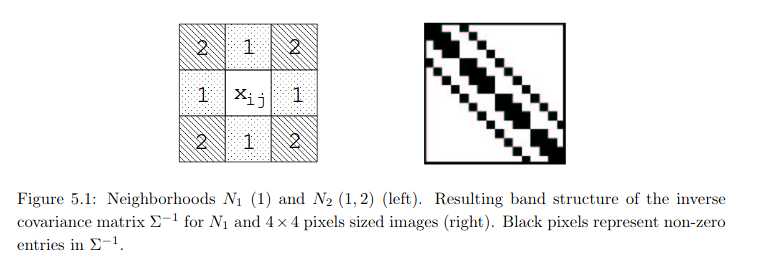

In this case only the upper/lower and left/right neighbours are non-zero in the precision matrix, i.e. a 4 points neighbourhood (figure and discussion from: http://www.keysers.net/daniel/files/da.pdf)

Also note that discontinuities due to the end pixel of a row not being a neighbour of the first pixel of the next row (no wrap around)

> Instead of modeling the precision matrix directly we can model its cholesky factor. The cholesky factor can be interpreted as the "square root" of a positive definite matrix (covariance, precision)

Let $L$ be the cholesky factor of 

$$
\Lambda = L^T L
$$

If $\Lambda$ is sparse then $L$ is also sparse, and modeling the cholesky factor is convenient because

$$
\Sigma = \Lambda^{-1} = (L^T L)^{-1} = L^{-1} L^{T^{-1}}  = L^{-1} L^{{-1}^T} 
$$

and with $L^{-1}$ we can sample from the $N(\mu, \Sigma)$ using the reparametrization trick

$$
x = \mu + L^{-1} \epsilon
$$

where $\epsilon \sim N(0, I)$

> The inverse of $L$ is also a triangular matrix and can be obtained easily with back-substitution. $\Lambda$ is positive definite if all elements in $L$'s diagonal are non-negative

Also note that

$$
- \frac{1}{2} \log |\Sigma| = \frac{1}{2} \log | \Lambda | = \frac{1}{2} \log | L |^2 = \log | L | = \sum_i \log L_{ii}
$$

and the log likelihood of the MVN with full covariance can be computed directly from L as

$$
\log N(\mu, \Sigma) = -\frac{d}{2} \log(2\pi) + \sum_{i=1}^{d} L_{ii} - \frac{1}{2} \| L (x - \mu) \|^2
$$

where $x \in \mathbb{R}^d$

We have 
- log likelihood evaluation from L
- sampling using L

This is all we need to train the VAE

## Experiment

- Create the Cholesky factor
- Inspect the resulting precision matrix
- Inspect the resulting covariance matrix
- Inspect the generated MVN samples

<IPython.core.display.Javascript object>


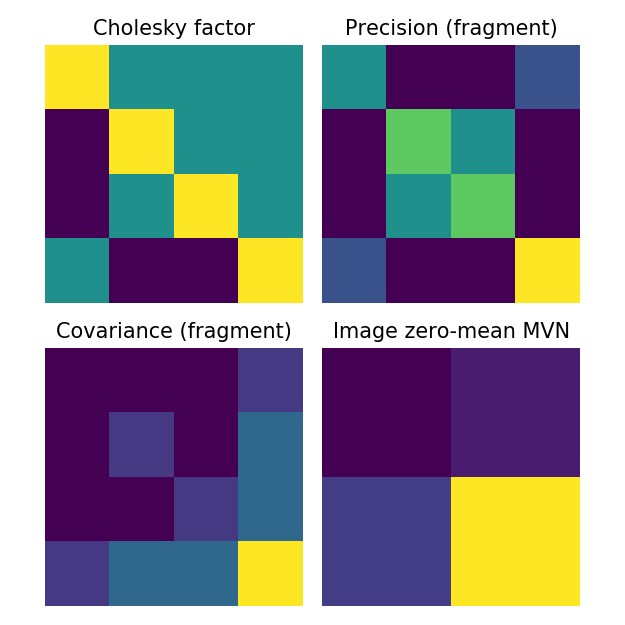

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='k', max=1.0, min=-1.0, step…

In [7]:
import numpy as np
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import widgets

N = 4
fig, ax = plt.subplots(2, 2, figsize=(5, 5), tight_layout=True)
    
def update(k, seed):
    np.random.seed(seed)
    # Lower triangular matrix
    L = np.zeros(shape=(N*N, N*N))
    i, j = np.indices(L.shape)
    L[i==j] = 1 # main diagonal
    L[(i==j+1) & ~(np.mod(i, N)==0)] = k # right neighbour
    L[(i == j+N) ] = k # lower neighbour
    # Precision matrix
    P = np.dot(L, L.T) 
    Linv = solve_triangular(L, np.eye(*L.shape), lower=True)
    S = np.dot(Linv, Linv.T)
    #sample = np.random.multivariate_normal(np.zeros(shape=(N*N)), S).reshape(N, N)
    sample = np.dot(Linv, np.random.randn(N*N)).reshape(N, N)
    for ax_ in ax.ravel():
        ax_.cla()
        ax_.axis('off')
    ax[0, 0].imshow(L[:, :])
    ax[0, 0].set_title('Cholesky factor')
    ax[0, 1].imshow(P[:, :])
    ax[0, 1].set_title('Precision (fragment)')
    ax[1, 0].imshow(S[:, :])
    ax[1, 0].set_title('Covariance (fragment)')
    ax[1, 1].imshow(sample)
    ax[1, 1].set_title('Image zero-mean MVN')
    
widgets.interact(update, k=widgets.FloatSlider(min=-1, max=1., step=0.01, continuous_update=False),
                 seed=widgets.IntSlider(min=0, max=10, continuous_update=False));

### TO-DO
- WHAT DOES A POSITIVE OR NEGATIVE $\Lambda[i, j]$ MEANS? https://online.stat.psu.edu/stat510/lesson/1/1.2
- FIX NUMERAL ERRORS ON INVERTION, FIND LIMIT TO $\Lambda_{ij}$
- GENERALIZE GRF TO 2D

### Appendix

- sparse inverse covariance estimation
- How strongly pixels correlate with neighbours: https://dahtah.github.io/imager/image_stats.html
- Covariance of covariance features: https://aimagelab.ing.unimore.it/imagelab/pubblicazioni/2014ICMR_covariance.pdf